In [54]:
# Import what we need for the job...
import keras
import numpy as np 
import matplotlib.pyplot as plt 
% matplotlib inline 

from keras_tqdm import TQDMNotebookCallback
# Visualization 
from IPython.display import SVG 
from IPython.display import display 
from keras.utils.vis_utils import model_to_dot

In [55]:
# length of sequences to model
length = 10

# make these the same for now
# set the input length
input_length = length
# set the output length
output_length = length

In [56]:
# generating a random string of 0s and 1s
# (1, 10, 1)
x_train = np.round(np.random.uniform(0,1,[length])).reshape([1,length,1])
x_train

array([[[ 1.],
        [ 1.],
        [ 1.],
        [ 0.],
        [ 0.],
        [ 1.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.]]])

In [57]:
# parity calculator
def parity(x):
    # create a 3d of 0s (1, 10, 1)
    temp = np.zeros(x.shape)
    
    # initialize mem
    mem = False
    
    # iterate over the sequence
    for i in range(x.shape[0]):
        # if 1, True
        # if 0, False
        current = True if x[i,0] > 0.5 else False
        
        # xor mem and curr
        mem = np.logical_xor(mem, current)
        
        # if mem True, temp i = 1.0
        # else temp i = 0.0
        temp[i,0] = 1.0 if mem else 0.0
        
    # return (1, 10, 1)
    return temp.reshape(1, temp.shape[0], temp.shape[1])


In [58]:
y_train = parity(x_train[0,:,:])
y_train

array([[[ 1.],
        [ 0.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.]]])

In [59]:
# encode X as input
X = np.expand_dims(keras.utils.to_categorical(x_train[0,:,0]), axis = 0)
X

array([[[ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  1.],
        [ 1.,  0.],
        [ 1.,  0.],
        [ 0.,  1.],
        [ 1.,  0.],
        [ 1.,  0.],
        [ 1.,  0.],
        [ 1.,  0.]]])

In [60]:
# encode Y as output
Y = np.expand_dims(np.vstack([np.array([0,0,1,0]),
                             np.hstack([keras.utils.to_categorical(y_train[0,:,0]),
                                       np.zeros([output_length, 2])]),
                             np.array([0,0,0,1])]), axis=0)
Y

array([[[ 0.,  0.,  1.,  0.],
        [ 0.,  1.,  0.,  0.],
        [ 1.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.],
        [ 0.,  1.,  0.,  0.],
        [ 0.,  1.,  0.,  0.],
        [ 1.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1.]]])

In [61]:
print(X.shape)
print(Y.shape)

(1, 10, 2)
(1, 12, 4)


In [62]:
# 12 time steps.. (10 + start + stop)
# 0 ... 10
preY = Y[:,0:output_length+1,:]

# 1 ... 11
postY = Y[:,1:output_length+2,:]

print(preY.shape)
print(postY.shape)

(1, 11, 4)
(1, 11, 4)


In [63]:
# size of gestalt context representation
hidden_size = input_length * 2

# encoder construction
# make layers
encoder_input = keras.layers.Input(shape= (None, X.shape[2]))
encoder_hidden = keras.layers.LSTM(hidden_size, return_state = True)

# tie the hidden layer to the input layer
encoder_output, enc_state_h, enc_state_c = encoder_hidden(encoder_input)

# discard encoder outputs and keep only the states
encoder_states = [enc_state_h, enc_state_c]


# decoder construction
# set up the decoder using encoder states as the initial state
decoder_input = keras.layers.Input(shape= (None, preY.shape[2]))
decoder_hidden = keras.layers.LSTM(hidden_size, return_sequences = True, return_state = True)

# connect hidden to input
decoder_hidden_output, decoder_state_h, decoder_state_c = decoder_hidden(decoder_input,
                                                                         initial_state = encoder_states)

decoder_dense = keras.layers.Dense(postY.shape[2], activation = 'softmax')

# connect output to hidden
decoder_output = decoder_dense(decoder_hidden_output)

# Our functoinal API model now has two input layers..
# 1. reads from X
# 2. reads from preY
# single output layer
#1. targets are postY
model = keras.Model([encoder_input, decoder_input], decoder_output)

# compile it
model.compile(loss = keras.losses.categorical_crossentropy,
              optimizer = keras.optimizers.Adam(),
              metrics = ['accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, None, 2)      0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           (None, None, 4)      0                                            
__________________________________________________________________________________________________
lstm_11 (LSTM)                  [(None, 20), (None,  1840        input_13[0][0]                   
__________________________________________________________________________________________________
lstm_12 (LSTM)                  [(None, None, 20), ( 2000        input_14[0][0]                   
                                                                 lstm_11[0][1]                    
          

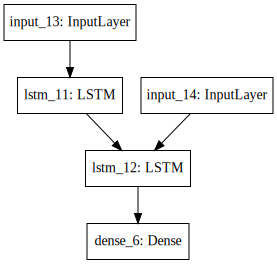

In [64]:
# visualization - wish we could see the recurrenct weights
SVG(model_to_dot(model).create(prog = 'dot', format = 'svg'))

In [65]:
# one pattern
batch_size = 1
epochs = 200
history = model.fit([X, preY], postY,
                     batch_size = batch_size,
                     epochs = epochs,
                     verbose = 0,
                     callbacks = [TQDMNotebookCallback()])
print('Accuracy:', model.evaluate([X,preY], postY)[1] * 100.0, '%')

HBox(children=(IntProgress(value=0, description='Training', max=200), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=1), HTML(value='')))


1/1 [==============================] - 1s 998ms/step
Accuracy: 90.9090936184 %


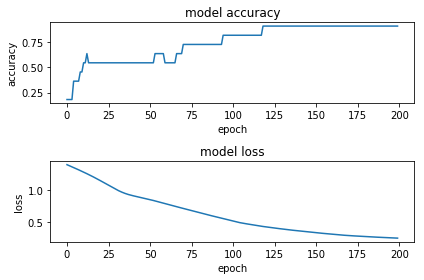

In [66]:
plt.figure(1)

plt.subplot(211)
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.subplot(212)
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.tight_layout()
plt.show()

In [67]:
# Part 1 - make the encoder
# Make just a model out of the encoder
# input = encoder_input (Input layer)
# output = encoder_states (enc Hidden layer * 2)
encoder_model=keras.Model(encoder_input,encoder_states)

# Part 2 - make the decoder
# Make just a model out of the decoder
# input = encoder_states (enc Hidden layer * 2)
# output = decoder_output
decoder_state_input_h=keras.layers.Input(shape=(hidden_size,))
decoder_state_input_c=keras.layers.Input(shape=(hidden_size,))

# Connect hidden to input(s)
decoder_states_input=[decoder_state_input_h,decoder_state_input_c]
decoder_hidden_output,decoder_state_h,decoder_state_c = decoder_hidden(decoder_input,
                                                                       initial_state=decoder_states_input)
decoder_states=[decoder_state_h,decoder_state_c]

# Connect output to hidden(s)
decoder_output=decoder_dense(decoder_hidden_output)
decoder_model=keras.Model([decoder_input]+decoder_states_input,[decoder_output]+decoder_states)

In [68]:
# get gestalt context for input sequences
context = encoder_model.predict(X)

# prep starting token [[[0,0,1,0]]]
token = np.zeros([1,1,Y.shape[2]])
token[0,0,2] = 1
token

array([[[ 0.,  0.,  1.,  0.]]])

In [70]:
# complete 11 cycles with decoder
result = np.zeros(postY.shape)
for x in range(output_length+1):
    out, h, c = decoder_model.predict([token] + context)
    token = np.round(out)
    context = [h,c]
    result[:,x,:] = token
result

array([[[ 0.,  1.,  0.,  0.],
        [ 0.,  1.,  0.,  0.],
        [ 0.,  1.,  0.,  0.],
        [ 0.,  1.,  0.,  0.],
        [ 0.,  1.,  0.,  0.],
        [ 1.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1.]]])

In [71]:
postY

array([[[ 0.,  1.,  0.,  0.],
        [ 1.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.],
        [ 0.,  1.,  0.,  0.],
        [ 0.,  1.,  0.,  0.],
        [ 1.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1.]]])

In [73]:
length = 10
input_length = length
output_length = length

# num of patters
n_seq = 100

# generate Xs
x_train = np.concatenate([np.round(np.random.uniform(0,1,[length])).reshape([1,length,1]) for x in range(n_seq)])
y_train=np.concatenate([parity(x_train[x,:,:]) for x in range(n_seq)])

# Reformat - dictionary approach
X=np.concatenate([np.expand_dims(keras.utils.to_categorical(x_train[x,:,:]),axis=0) for x in range(n_seq)])
Y=np.concatenate([np.expand_dims(np.vstack([np.array([0,0,1,0]),
                  np.hstack([keras.utils.to_categorical(y_train[x,:,:]),np.zeros([output_length,2])]),
                  np.array([0,0,0,1])]),axis=0) for x in range(n_seq)])

preY=Y[:,0:length+1,:]
postY=Y[:,1:length+2,:]

In [74]:
print(X.shape)
print(Y.shape)
print(preY.shape)
print(postY.shape)

(100, 10, 2)
(100, 12, 4)
(100, 11, 4)
(100, 11, 4)


In [75]:
# size of gestalt context representation
hidden_size = input_length * 2

# encoder construction
# make layers
encoder_input = keras.layers.Input(shape= (None, X.shape[2]))
encoder_hidden = keras.layers.LSTM(hidden_size, return_state = True)

# tie the hidden layer to the input layer
encoder_output, enc_state_h, enc_state_c = encoder_hidden(encoder_input)

# discard encoder outputs and keep only the states
encoder_states = [enc_state_h, enc_state_c]


# decoder construction
# set up the decoder using encoder states as the initial state
decoder_input = keras.layers.Input(shape= (None, preY.shape[2]))
decoder_hidden = keras.layers.LSTM(hidden_size, return_sequences = True, return_state = True)

# connect hidden to input
decoder_hidden_output, decoder_state_h, decoder_state_c = decoder_hidden(decoder_input,
                                                                         initial_state = encoder_states)

decoder_dense = keras.layers.Dense(postY.shape[2], activation = 'softmax')

# connect output to hidden
decoder_output = decoder_dense(decoder_hidden_output)

# Our functoinal API model now has two input layers..
# 1. reads from X
# 2. reads from preY
# single output layer
#1. targets are postY
model = keras.Model([encoder_input, decoder_input], decoder_output)

# compile it
model.compile(loss = keras.losses.categorical_crossentropy,
              optimizer = keras.optimizers.Adam(),
              metrics = ['accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, None, 2)      0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           (None, None, 4)      0                                            
__________________________________________________________________________________________________
lstm_13 (LSTM)                  [(None, 20), (None,  1840        input_17[0][0]                   
__________________________________________________________________________________________________
lstm_14 (LSTM)                  [(None, None, 20), ( 2000        input_18[0][0]                   
                                                                 lstm_13[0][1]                    
          

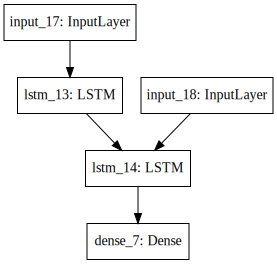

In [76]:
# visualization - wish we could see the recurrenct weights
SVG(model_to_dot(model).create(prog = 'dot', format = 'svg'))

In [77]:
# one pattern
batch_size = 20
epochs = 1500
history = model.fit([X, preY], postY,
                     batch_size = batch_size,
                     epochs = epochs,
                     verbose = 0,
                     callbacks = [TQDMNotebookCallback()],
                     validation_split=0.2)
print('Accuracy:', model.evaluate([X,preY], postY)[1] * 100.0, '%')

HBox(children=(IntProgress(value=0, description='Training', max=1500), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=80), HTML(value='')))

/home/csci4850/lib/python3.5/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102578). Check your callbacks.
  % delta_t_median)



100/100 [==============================] - 0s 703us/step
Accuracy: 92.2727274895 %


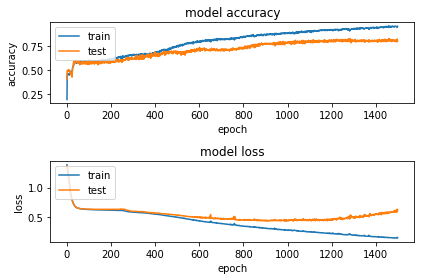

In [78]:
plt.figure(1)

plt.subplot(211)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.tight_layout()
plt.show()

In [79]:
# testing

# Part 1 - make the encoder
# Make just a model out of the encoder
# input = encoder_input (Input layer)
# output = encoder_states (enc Hidden layer * 2)
encoder_model=keras.Model(encoder_input,encoder_states)

# Part 2 - make the decoder
# Make just a model out of the decoder
# input = encoder_states (enc Hidden layer * 2)
# output = decoder_output
decoder_state_input_h=keras.layers.Input(shape=(hidden_size,))
decoder_state_input_c=keras.layers.Input(shape=(hidden_size,))

# Connect hidden to input(s)
decoder_states_input=[decoder_state_input_h,decoder_state_input_c]
decoder_hidden_output,decoder_state_h,decoder_state_c = decoder_hidden(decoder_input,
                                                                       initial_state=decoder_states_input)
decoder_states=[decoder_state_h,decoder_state_c]

# Connect output to hidden(s)
decoder_output=decoder_dense(decoder_hidden_output)
decoder_model=keras.Model([decoder_input]+decoder_states_input,[decoder_output]+decoder_states)

In [80]:
error = 0
for p in range(n_seq):
    # get gestalt context from input seq
    context = encoder_model.predict(X[p:p+1,:,:])
    
    # prep starting token [[[0,0,1,0]]]
    token = np.zeros([1,1,Y.shape[2]])
    token[0,0,2] = 1
    token
    
    # complete 11 cycles
    result = np.zeros(postY.shape)
    for x in range(output_length + 1):
        out, h, c = decoder_model.predict([token] + context)
        token = np.round(out)
        context = [h,c]
        result[:,x,:] = token
    error += np.sum(np.abs(result - postY[p:p+1,:,:]))/ 2.0

In [82]:
print("Overall accuracy: %f%%" %(100.00 - (error / (n_seq * output_length))))

Overall accuracy: 84.900000%
